# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

## **Import**

In [77]:
import os
import numpy as np
from sklearn import metrics
import random
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

import torch
import torchvision
from torchvision.datasets import FakeData
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
from torchvision.models.resnet import BasicBlock

from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FakeData, CIFAR10





### ***Further settings***

In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
SEED = 808
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

# ***Import Exercise1 ResCNN_Model architecture and weights***

In [79]:

class VariableDepthResNet(nn.Module):
    def __init__(self, num_blocks, num_classes, base_channels, dropout_rate, in_channels, padding):
        super().__init__()
        # Initial convolution + batch norm + activation
        self.conv1 = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.relu = nn.ReLU(inplace=True)

        # Stack residual blocks
        layers = []
        for _ in range(num_blocks):
            layers.append(BasicBlock(base_channels, base_channels))
        self.res_blocks = nn.Sequential(*layers)

        # Global average pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout + final classifier
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(base_channels, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  
        x = self.res_blocks(x)                  
        x = self.pool(x)                       
        x = torch.flatten(x, 1)                  
        x = self.dropout(x)                     
        return self.fc(x)                        



#model istance
model = VariableDepthResNet(
    num_blocks=4,
    num_classes=10,
    base_channels=32,
    dropout_rate=0.2,
    in_channels=3,
    padding=1
).to(device)

state_dict = torch.load( r"models\best_model_ResCNN.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

C:\Users\emile\AppData\Local\Temp\ipykernel_19272\304565346.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load( r"models\best_model_ResCNN.pth", ma

VariableDepthResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (res_blocks): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=

### **Load Data CIFAR-10**

In [80]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, 
                         num_workers=8, persistent_workers=True)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, 
                        num_workers=8, persistent_workers=True)

Files already downloaded and verified
Files already downloaded and verified


### **Load Fake dataset**

In [81]:

fakeset = FakeData(size=1000, image_size=(3,32,32), transform=transform)
fakeloader = DataLoader(fakeset, batch_size=128, shuffle=False)

### *Visualize a sample from FakeData*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


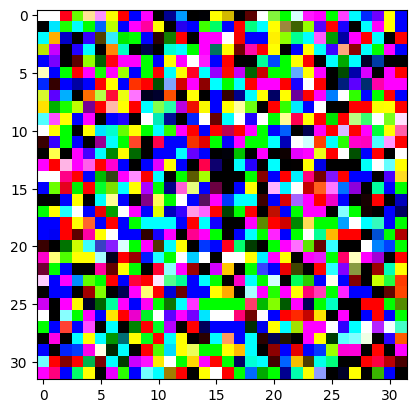

torch.Size([128, 3, 32, 32]) airplane


In [82]:
for data in fakeloader:
    x, y = data
    plt.imshow(x[0].permute(1, 2, 0))  # convert from (C,H,W) to (H,W,C)
    plt.show()
    break

print(x.shape, trainset.classes[y[80]])

## **scores function**

In [83]:
def get_max_softmax_scores(model, dataloader, device):
    model.eval()
    scores = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            max_scores, _ = torch.max(probs, dim=1)
            scores.extend(max_scores.cpu().numpy())
    return np.array(scores)


## **Model evaluation**

Accuracy: 0.7705


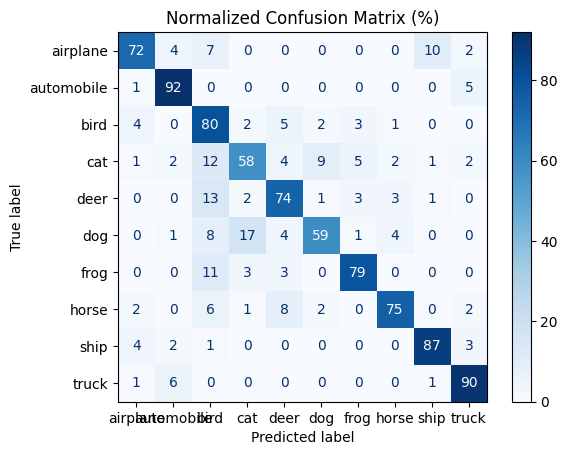

In [84]:
# Ensure the model is in evaluation mode
model.eval()
y_pred = []
y_gt = []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get predicted class
        preds = torch.argmax(outputs, dim=1)
        
    
        y_pred.append(preds.cpu())
        y_gt.append(labels.cpu())

y_pred_t = torch.cat(y_pred)
y_gt_t = torch.cat(y_gt)
accuracy = metrics.accuracy_score(y_gt_t.numpy(), y_pred_t.numpy())
print(f'Accuracy: {accuracy:.4f}')

# Compute confusion matrix
cm = metrics.confusion_matrix(y_gt_t.numpy(), y_pred_t.numpy())
cmn = cm.astype(np.float32)
cmn /= cmn.sum(axis=1)[:, np.newaxis]
# Convert to percentages
cmn = (100 * cmn).astype(np.int32)

disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Normalized Confusion Matrix (%)")
plt.show()


### **Logits and Softmax plot for OOD and ID**

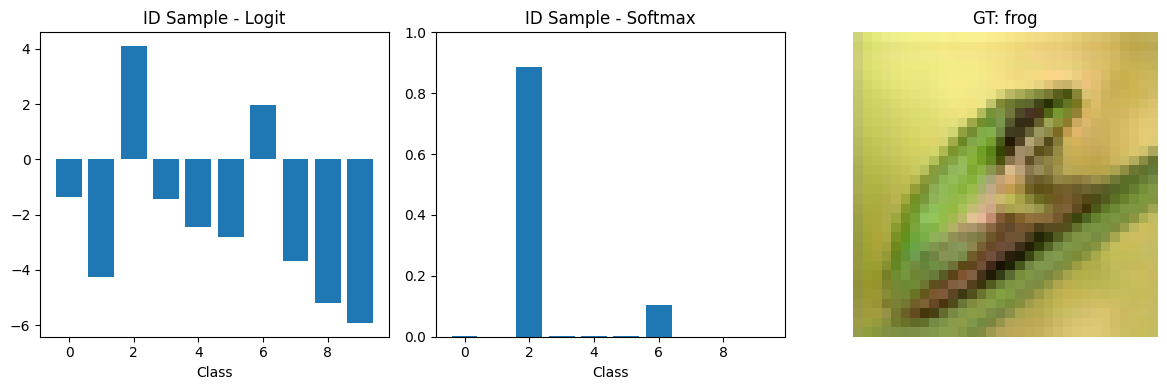

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


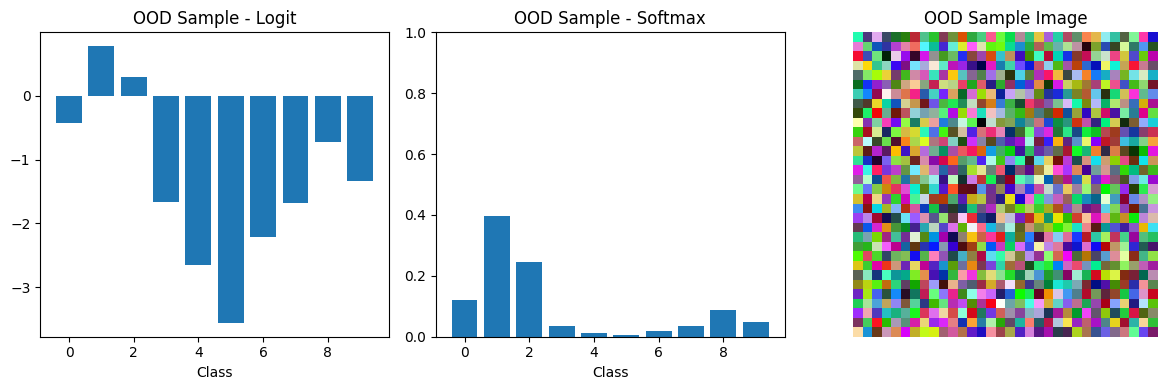

In [90]:
model.eval()
# Pick one random sample from ID dataset
x_id, y_id = next(iter(testloader))
k_id = random.randint(0, x_id.shape[0]-1)
x_id, y_id = x_id.to(device), y_id.to(device)

# Pick one random sample from OOD dataset
x_ood, _ = next(iter(fakeloader))
k_ood = random.randint(0, x_ood.shape[0]-1)
x_ood = x_ood.to(device)

 # Plots logit, softmax, and image for a single sample from a batch.
def plot_sample_logit_softmax_image(x_batch, k, title, y_batch=None, class_names=None):



    with torch.no_grad():
        output = model(x_batch)
    
    logits = output[k].detach().cpu()
    softmax_probs = F.softmax(output, dim=1)[k].detach().cpu()
    plt.figure(figsize=(12,4))
    
    # Logit plot
    plt.subplot(1,3,1)
    plt.bar(range(len(logits)), logits)
    plt.title(f'{title} - Logit')
    plt.xlabel('Class')
    # Softmax plot
    plt.subplot(1,3,2)
    plt.bar(range(len(softmax_probs)), softmax_probs)
    plt.title(f'{title} - Softmax')
    plt.ylim(0,1)
    plt.xlabel('Class')
    # Image
    plt.subplot(1,3,3)
    img = x_batch[k].cpu().permute(1,2,0)
    
    # Undo normalization for visualization

    mean = torch.tensor([0.4914, 0.4822, 0.4465])
    std  = torch.tensor([0.2023, 0.1994, 0.2010])
    img = img * std + mean
    plt.imshow(img)
    if y_batch is not None and class_names is not None:
        plt.title(f'GT: {class_names[y_batch[k].cpu()]}')
    else:
        plt.title(f'{title} Image')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_logit_softmax_image(x_id, k_id, "ID Sample", y_id, testset.classes)
plot_sample_logit_softmax_image(x_ood, k_ood, "OOD Sample")


## ***overlapping histogram***

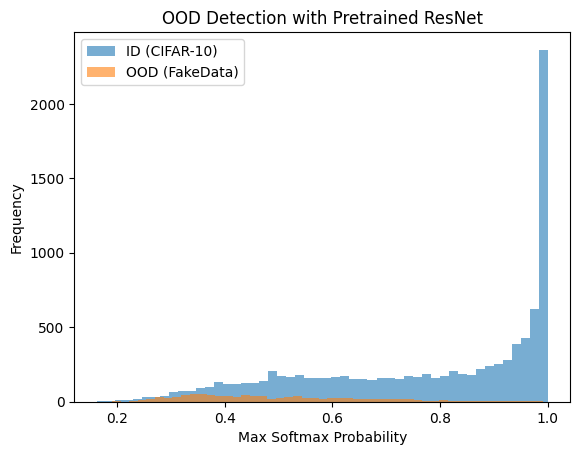

In [42]:
id_scores = get_max_softmax_scores(model, testloader, device)
ood_scores = get_max_softmax_scores(model, fakeloader, device)

#Plot scores
plt.hist(id_scores, bins=50, alpha=0.6, label="ID (CIFAR-10)")
plt.hist(ood_scores, bins=50, alpha=0.6, label="OOD (FakeData)")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Frequency")
plt.legend()
plt.title("OOD Detection with Pretrained ResNet")
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



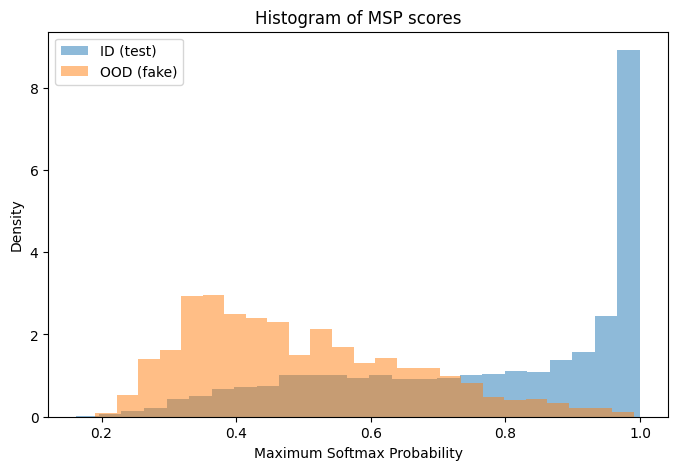


 ***Overlap area**= 0.4758



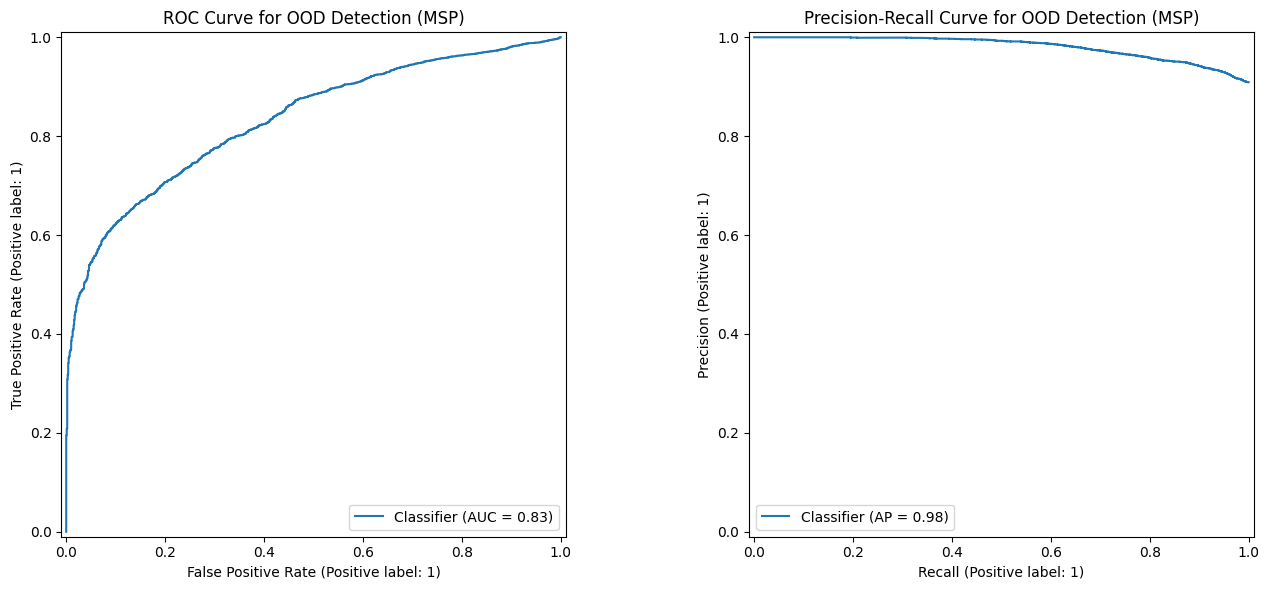

In [67]:
# Plot histograms with density
plt.figure(figsize=(8,5))
plt.hist(id_scores, density=True, alpha=0.5, bins=25, label='ID (test)')
plt.hist(ood_scores, density=True, alpha=0.5, bins=25, label='OOD (fake)')
plt.xlabel('Maximum Softmax Probability')
plt.ylabel('Density')
plt.title('Histogram of MSP scores')
plt.legend()
plt.show()

# Define common bins
bins = np.linspace(0, 1, 50)
# Compute histograms as probability densities
hist_id, _ = np.histogram(id_scores, bins=bins, density=True)
hist_ood, _ = np.histogram(ood_scores, bins=bins, density=True)

# Calculate the overlap area
bin_width = bins[1] - bins[0]
overlap_area = np.sum(np.minimum(hist_id, hist_ood)) * bin_width
print(f"\n ***Overlap area**= {overlap_area:.4f}\n")

# Prepare labels for ROC / PR
y_true = np.concatenate([np.ones_like(id_scores), np.zeros_like(ood_scores)])
y_scores = np.concatenate([id_scores, ood_scores])

#Curves
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# ROC Curve
RocCurveDisplay.from_predictions(y_true, y_scores, ax=axes[0])
axes[0].set_title("ROC Curve for OOD Detection (MSP)")

# Precision-Recall Curve 
PrecisionRecallDisplay.from_predictions(y_true, y_scores, ax=axes[1])
axes[1].set_title("Precision-Recall Curve for OOD Detection (MSP)")

plt.tight_layout()
plt.show()


---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [71]:
for i,c in enumerate(testset.classes):
    print(f"-{i}:{c}\n ")

-0:airplane
 
-1:automobile
 
-2:bird
 
-3:cat
 
-4:deer
 
-5:dog
 
-6:frog
 
-7:horse
 
-8:ship
 
-9:truck
 


In [114]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
# Inverse normalization for CIFAR-10
inv = NormalizeInverse(
    mean=(0.4914, 0.4822, 0.4465),
    std=(0.2023, 0.1994, 0.2010)
)

# FGSM attack for a batch
def fgsm_batch(model, images, labels, epsilon, targeted=False, target_label=None):
    model.eval()
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    
    if targeted and target_label is None:
        raise ValueError("Specify target_label for targeted attack")
    
    images.requires_grad = True
    outputs = model(images)
    
    # choose labels for loss
    if targeted:
        targets = torch.ones_like(labels)*target_label
    else:
        targets = labels
    
    loss = F.cross_entropy(outputs, targets)
    model.zero_grad()
    loss.backward()
    
    # create adversarial images
    if targeted:
        adv_images = images - epsilon*images.grad.sign()
    else:
        adv_images = images + epsilon*images.grad.sign()
    
    return adv_images



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098022..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05704922..1.0060692].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8753297e-07..0.96862763].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00606919..0.97073615].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8753297e-07..0.8274512].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.8753297e-07..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got r

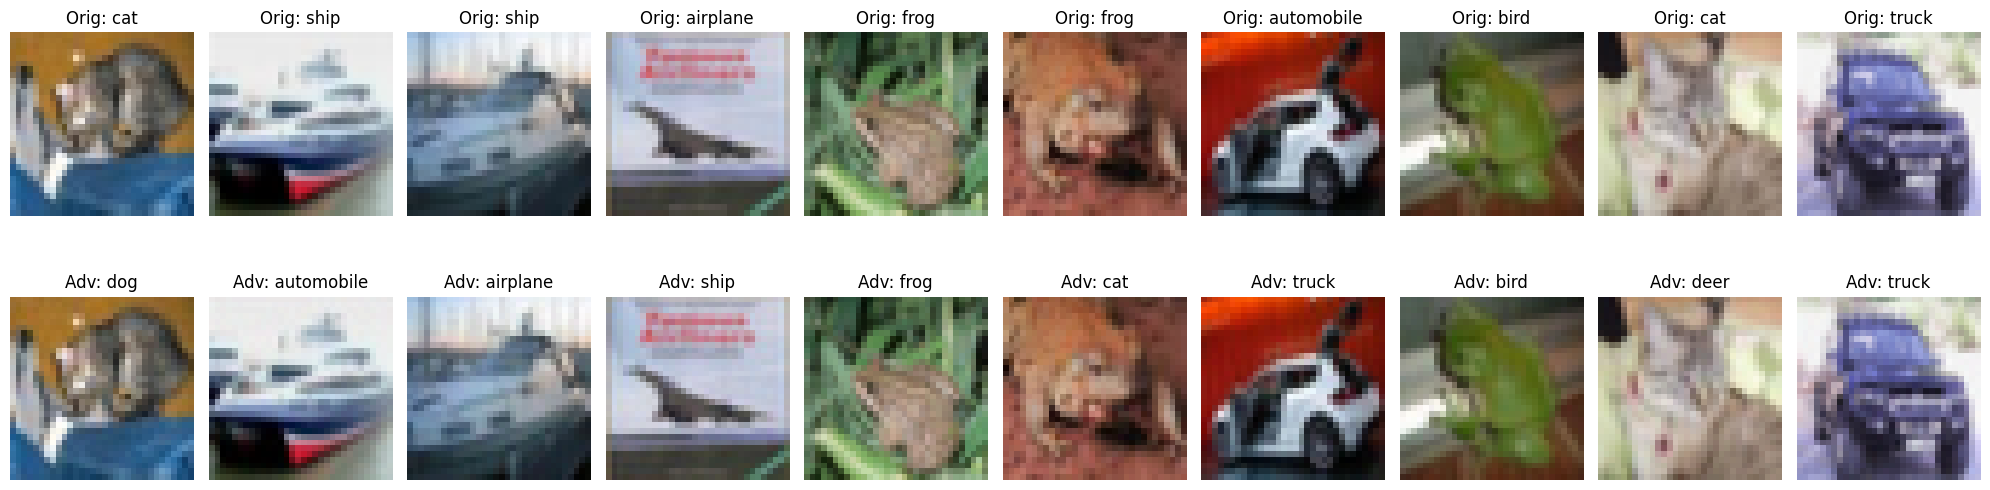

In [156]:
# Example: attack first batch of testloader
epsilon = 0.03
data_iter = iter(testloader)
images, labels = next(data_iter)

adv_images = fgsm_batch(model, images, labels, epsilon)

# Accuracy on adversarial batch
# Calcola predizioni originali e adversarial
model.eval()
with torch.no_grad():
    preds_orig = model(images.to(device)).argmax(dim=1)
    preds_adv = model(adv_images.to(device)).argmax(dim=1)

plt.figure(figsize=(20,6))
for i in range(10):
    # Immagine originale
    plt.subplot(2,10,i+1)
    plt.imshow(inv(images[i]).permute(1,2,0).cpu())
    plt.title(f"Orig: {testset.classes[preds_orig[i]]}")
    plt.axis('off')
    
    # Immagine adversarial
    plt.subplot(2,10,i+11)
    plt.imshow(inv(adv_images[i].detach()).permute(1,2,0).cpu())
    plt.title(f"Adv: {testset.classes[preds_adv[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098022..1.0000002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05704922..1.0060692].


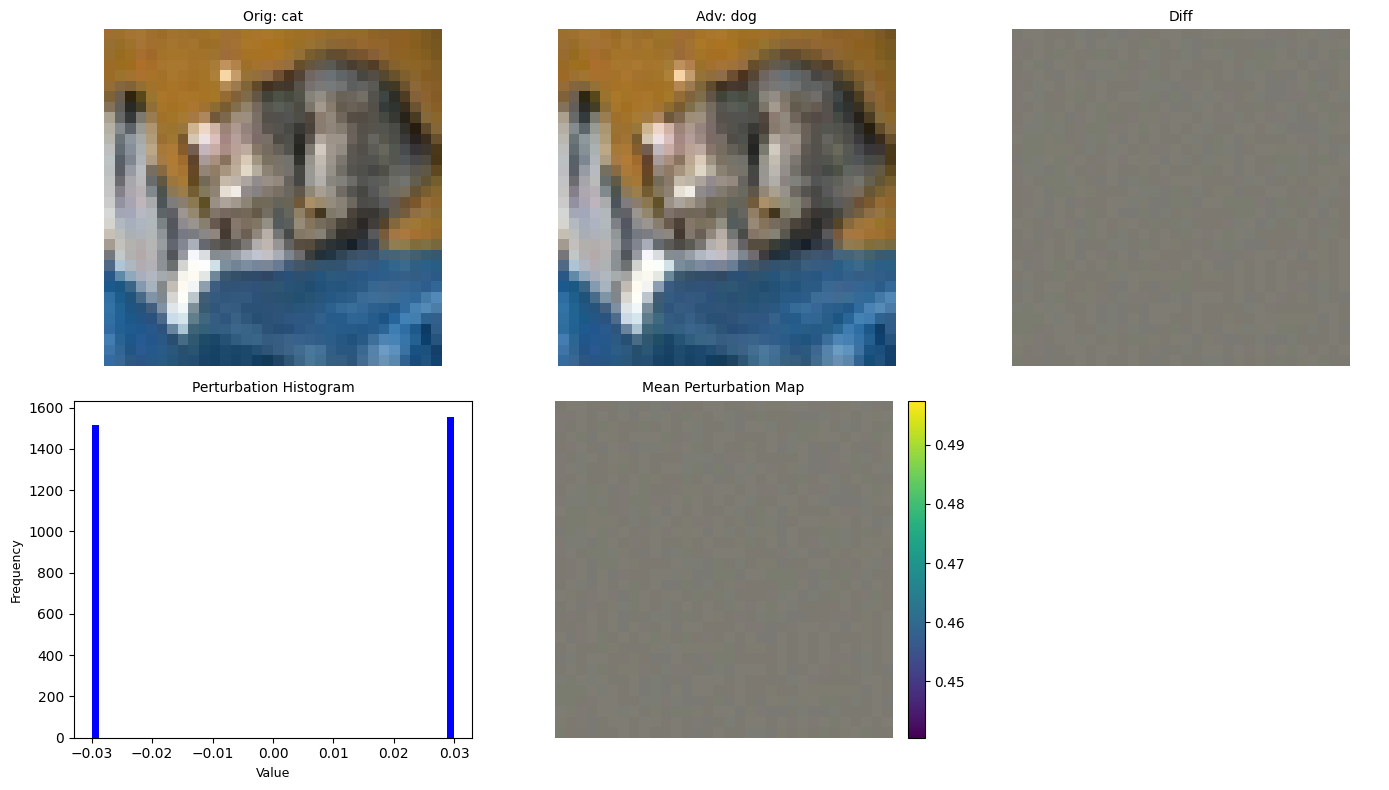

In [169]:
# Seleziona un'immagine dal batch
idx = 0
img_orig = images[idx].unsqueeze(0).to(device)
img_adv = adv_images[idx].unsqueeze(0).to(device)

# Calcolo predizioni
model.eval()
with torch.no_grad():
    pred_orig = model(img_orig).argmax(dim=1).item()
    pred_adv = model(img_adv).argmax(dim=1).item()

# Sposta i tensori su CPU
img_orig_cpu = img_orig.cpu()
img_adv_cpu = img_adv.cpu()
diff = img_adv_cpu - img_orig_cpu

# Istogramma della perturbazione
diff_flat = diff.flatten().detach().cpu().numpy()

# Mappa di intensità della perturbazione
diff_mean = diff.mean(0).detach()

# Visualizzazione compatta con meno spazi
fig, axes = plt.subplots(2, 3, figsize=(14,8) )

# Row 1: immagini
axes[0,0].imshow(inv(img_orig_cpu[0]).permute(1,2,0))
axes[0,0].set_title(f"Orig: {testset.classes[pred_orig]}", fontsize=10)
axes[0,0].axis('off')

axes[0,1].imshow(inv(img_adv_cpu[0].detach()).permute(1,2,0))
axes[0,1].set_title(f"Adv: {testset.classes[pred_adv]}", fontsize=10)
axes[0,1].axis('off')

axes[0,2].imshow(inv(diff[0].detach()).permute(1,2,0))
axes[0,2].set_title("Diff", fontsize=10)
axes[0,2].axis('off')

# Row 2: histogram e heatmap
axes[1,0].hist(diff_flat, bins=50, color='blue')  # colore vivo
axes[1,0].set_title("Perturbation Histogram", fontsize=10)
axes[1,0].set_xlabel("Value", fontsize=9)
axes[1,0].set_ylabel("Frequency", fontsize=9)

im = axes[1,1].imshow(inv(diff_mean).permute(1,2,0))
axes[1,1].set_title("Mean Perturbation Map", fontsize=10)
axes[1,1].axis('off')
fig.colorbar(im, ax=axes[1,1], fraction=0.046, pad=0.04)

# L'ultima subplot rimane vuota
axes[1,2].axis('off')

plt.tight_layout()
plt.show()


Step 1, model predicts: ship
Step 2, model predicts: bird
Step 3, model predicts: bird
Step 4, model predicts: bird
Step 5, model predicts: deer
Step 6, model predicts: horse
Target achieved in 6 steps!


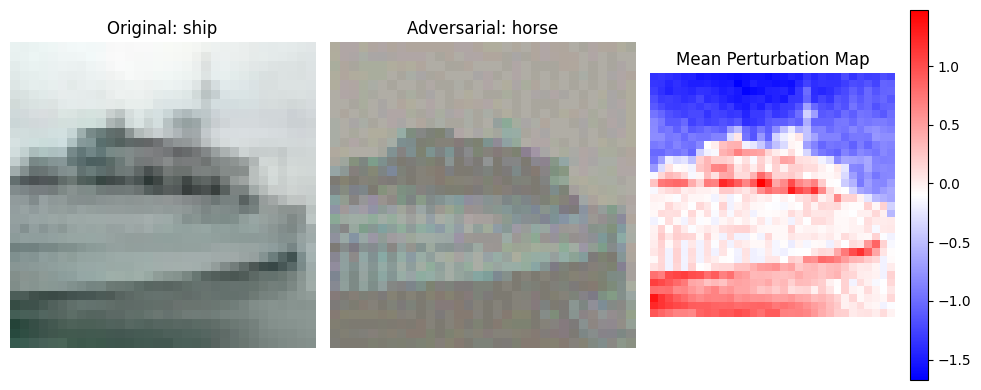

In [173]:
# Choose one sample
sample_id = 80  # index of the image in testloader batch
epsilon = 0.03  # perturbation budget per step
target_class_name = 'horse'  # class we want the model to predict
target_label = class_dict[target_class_name]

# Get one batch from testloader
data_iter = iter(testloader)
images, labels = next(data_iter)
x = images[sample_id].unsqueeze(0).to(device)  # add batch dimension
y = labels[sample_id].unsqueeze(0).to(device)

# Make image require grad
x.requires_grad = True


# Targeted attack loop
done = False
step = 0
while not done:
    model.zero_grad()
    outputs = model(x)
    loss = F.cross_entropy(outputs, torch.tensor([target_label], device=device))
    loss.backward()
    
    # FGSM targeted: move opposite direction of gradient
    with torch.no_grad():
        x -= epsilon * x.grad.sign()
        x.clamp_(0, 1)
    
    x.requires_grad = True  # re-enable gradient for next step
    
    step += 1
    pred = outputs.argmax(dim=1).item()
    print(f"Step {step}, model predicts: {testset.classes[pred]}")
    
    if pred == target_label:
        print(f"Target achieved in {step} steps!")
        done = True

# Prepare images for visualization
adv_img = x.detach()
orig_img = images[sample_id].unsqueeze(0).to(device)
diff = adv_img - orig_img

# Plot original, adversarial, and mean perturbation map
plt.figure(figsize=(10,4))

# Original image
plt.subplot(1,3,1)
plt.imshow(inv(orig_img[0]).permute(1,2,0).cpu())
plt.title(f"Original: {testset.classes[y.item()]}")
plt.axis('off')

# Adversarial image
plt.subplot(1,3,2)
plt.imshow(inv(adv_img[0]).permute(1,2,0).cpu())
plt.title(f"Adversarial: {testset.classes[target_label]}")
plt.axis('off')

# Mean perturbation map
plt.subplot(1,3,3)
pert_map = diff.squeeze().mean(dim=0)  # mean over channels
plt.imshow(pert_map.cpu(), cmap='bwr')
plt.colorbar()
plt.title("Mean Perturbation Map")
plt.axis('off')

plt.tight_layout()
plt.show()


### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [ ]:
# Your code here.

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.
